In [61]:
import os
import pandas as pd 
import shutil
import configparser
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso

In [170]:
dirCat=r'D:\Sources\COSMOS_photoZ\COSMOS_v3.0\catalogs\forPaper\v05'
fileNameCat=r'05_COSMOS_SpectrZ_Zlim_1p2_AllBands_colors.csv'
idcolumn='Seq'
zspeccolumn='z_spec'
cat=pd.read_csv(os.path.join(dirCat,fileNameCat))

In [174]:
magsBroad=[c for c in cat.columns if 'magap3'  in c]
magsNarrow=[c for c in cat.columns if ('ap3' in c and 'mag' not in c)]
colors=['u-B', 'B-V', 'V-r', 'r-ip', 'ip-zpp', 'zpp-Y', 'Y-J',
       'J-H', 'H-Ks']

Text(0.5, 1, 'Broad bands')

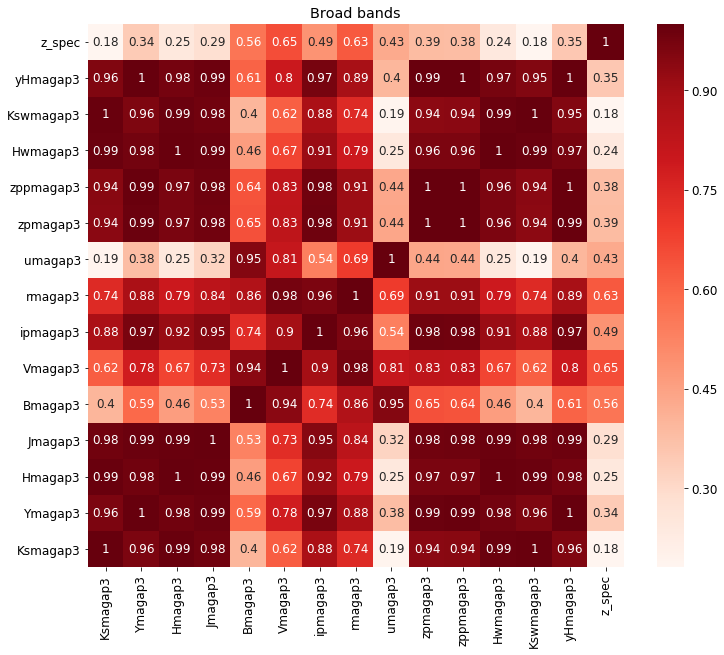

In [186]:
fig,ax=plt.subplots(1,1,figsize=(12,10))
plt.rcParams.update({'font.size': 12})
catWork=cat[magsBroad+[zspeccolumn]]
cor = catWork.corr()
ax=sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
ax.set_ylim([0,len(magsBroad)+1])
#ax.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xmajorticklabels(), fontsize = 16)
ax.set_title('Broad bands')

Text(0.5, 1, 'Narrow bands')

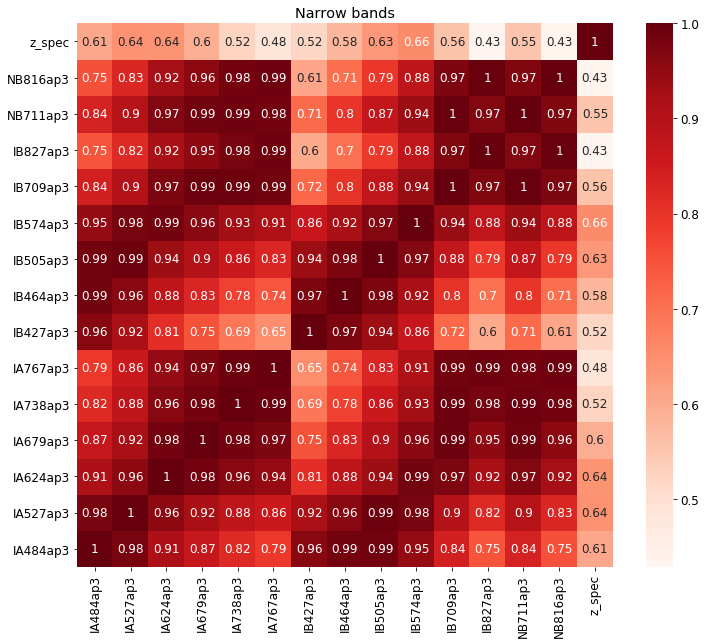

In [187]:
fig,ax=plt.subplots(1,1,figsize=(12,10))
catWork=cat[magsNarrow+[zspeccolumn]]
cor = catWork.corr()
ax=sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
ax.set_ylim([0,len(magsNarrow)+1])
ax.set_title('Narrow bands')

Text(0.5, 1, 'Colours')

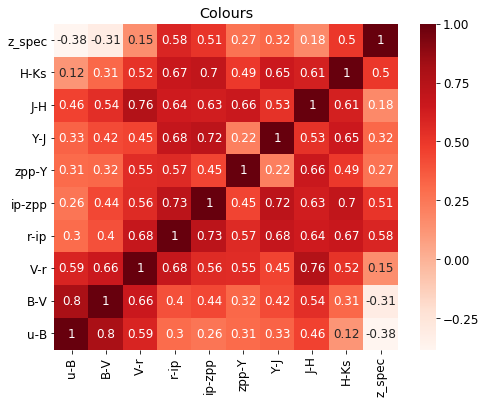

In [191]:
fig,ax=plt.subplots(1,1,figsize=(7.7,6))
catWork=cat[colors+[zspeccolumn]]
cor = catWork.corr()
ax=sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
ax.set_ylim([0,len(colors)+1])
ax.set_title('Colours')

In [88]:
catWork=cat[magsBroad+magsNarrow+colors+[zspeccolumn]]
cor = catWork.corr()
cor_target = abs(cor[zspeccolumn])
relSpec = cor_target[cor_target>0.5]
relSpec.sort_values(ascending=False)[1:11]

IB574ap3    0.655189
Vmagap3     0.652767
IA527ap3    0.643980
IA624ap3    0.640768
IB505ap3    0.631686
rmagap3     0.626740
IA484ap3    0.606074
IA679ap3    0.595878
r-ip        0.584477
IB464ap3    0.581661
Name: z_spec, dtype: float64

In [36]:
## Wrapper methods
import statsmodels.api as sm

In [92]:
X = cat[magsBroad+magsNarrow+colors]   #Feature Matrix
Y = cat[zspeccolumn] 

In [93]:
from sklearn.ensemble import GradientBoostingRegressor

In [94]:
model=GradientBoostingRegressor(n_estimators=100, learning_rate=0.1,
                          max_depth=1, random_state=0, loss='ls')
#Initializing RFE model
rfe = RFE(model, 10)
#Transforming data using RFE
X_rfe = rfe.fit_transform(X,Y)  
#Fitting the data to model
model.fit(X_rfe,Y)
print(list(zip(rfe.support_,rfe.ranking_)))

[(False, 28), (False, 27), (False, 26), (False, 25), (False, 24), (True, 1), (False, 15), (False, 14), (False, 13), (False, 11), (False, 9), (False, 7), (False, 6), (False, 17), (False, 19), (True, 1), (True, 1), (False, 5), (True, 1), (False, 21), (False, 23), (False, 22), (False, 20), (True, 1), (False, 12), (False, 10), (False, 8), (False, 4), (True, 1), (True, 1), (False, 18), (True, 1), (True, 1), (False, 16), (False, 3), (False, 2), (True, 1)]


In [95]:
cols = list(X.columns)         
temp = pd.Series(rfe.support_,index = cols)
selected_features_rfe = temp[temp==True].index
print(selected_features_rfe)

Index(['Vmagap3', 'IA527ap3', 'IA624ap3', 'IA738ap3', 'IB574ap3', 'u-B', 'B-V',
       'r-ip', 'ip-zpp', 'H-Ks'],
      dtype='object')


In [97]:
from sklearn.metrics import mean_squared_error

In [99]:
x=X[selected_features_rfe]
X_train=x[0:16000]
Y_train=Y[0:16000]
X_test=x[16000:]
Y_test=Y[16000:]

In [109]:
import func_stat

In [110]:
### Create resid column ###
def residCol(df,colSpectrZ, colPhotoZ,colResid):
    df[colResid]=(df[colSpectrZ]-df[colPhotoZ])/(df[colSpectrZ]+1)
    return df

In [138]:
est = GradientBoostingRegressor(n_estimators=1200, learning_rate=0.005,
                                max_depth=7, random_state=0, loss='ls').fit(X_train, Y_train)
mean_squared_error(Y_test, est.predict(X_test))

0.007141474844124694

In [139]:
df=pd.DataFrame(columns=['specZ','photoZ'])
df['specZ']=Y_test
df['photoZ']=est.predict(X_test)
df=residCol(df,colSpectrZ='specZ', colPhotoZ='photoZ',colResid='resid')
func_stat.statResid(df,colResid='resid')

{'Num objects': 3176,
 'Std': 0.058,
 'NMAD': 0.024,
 'Mean': -0.0043,
 '% outl_15': 2.61}

In [140]:
x=X[magsBroad]
X_train=x[0:16000]
Y_train=Y[0:16000]
X_test=x[16000:]
Y_test=Y[16000:]

est = GradientBoostingRegressor(n_estimators=1200, learning_rate=0.005,
                                max_depth=7, random_state=0, loss='ls').fit(X_train, Y_train)
mean_squared_error(Y_test, est.predict(X_test))

df=pd.DataFrame(columns=['specZ','photoZ'])
df['specZ']=Y_test
df['photoZ']=est.predict(X_test)
df=residCol(df,colSpectrZ='specZ', colPhotoZ='photoZ',colResid='resid')
func_stat.statResid(df,colResid='resid')

{'Num objects': 3176,
 'Std': 0.062,
 'NMAD': 0.032,
 'Mean': -0.0051,
 '% outl_15': 2.9}

In [141]:
x=X[selected_features_rfe]
X_train=x[0:16000]
Y_train=Y[0:16000]
X_test=x[16000:]
Y_test=Y[16000:]

est = GradientBoostingRegressor(n_estimators=1200, learning_rate=0.005,
                                max_depth=7, random_state=0, loss='huber').fit(X_train, Y_train)
mean_squared_error(Y_test, est.predict(X_test))

df=pd.DataFrame(columns=['specZ','photoZ'])
df['specZ']=Y_test
df['photoZ']=est.predict(X_test)
df=residCol(df,colSpectrZ='specZ', colPhotoZ='photoZ',colResid='resid')
func_stat.statResid(df,colResid='resid')

{'Num objects': 3176,
 'Std': 0.058,
 'NMAD': 0.022,
 'Mean': -0.0049,
 '% outl_15': 2.74}

In [142]:
testPhiLab=pd.read_csv(os.path.join('D:\Sources\COSMOS_photoZ\COSMOS_v3.0\PhiLab','8Features_MLPQNA_Test_Output.csv'))

In [144]:
func_stat.statResid(testPhiLab,colResid='resid')

{'Num objects': 6179,
 'Std': 0.048,
 'NMAD': 0.021,
 'Mean': -0.0015,
 '% outl_15': 1.93}

In [146]:
testPhiLab162=pd.read_csv(os.path.join('D:\Sources\COSMOS_photoZ\COSMOS_v3.0\PhiLab','162Features_RandomForest_Test_Output.csv'))
func_stat.statResid(testPhiLab162,colResid='resid')

{'Num objects': 6179,
 'Std': 0.049,
 'NMAD': 0.012,
 'Mean': -0.0025,
 '% outl_15': 1.84}

In [148]:
from sklearn.ensemble import RandomForestRegressor

In [153]:
x=X[magsBroad]
X_train=x[0:16000]
Y_train=Y[0:16000]
X_test=x[16000:]
Y_test=Y[16000:]

In [154]:
regr = RandomForestRegressor(random_state=0)
regr.fit(X_train, Y_train)
df=pd.DataFrame(columns=['specZ','photoZ'])
df['specZ']=Y_test
df['photoZ']=regr.predict(X_test)
df=residCol(df,colSpectrZ='specZ', colPhotoZ='photoZ',colResid='resid')
func_stat.statResid(df,colResid='resid')

{'Num objects': 3176,
 'Std': 0.059,
 'NMAD': 0.026,
 'Mean': -0.0037,
 '% outl_15': 2.71}

In [159]:
x=X[colors+magsNarrow+magsBroad]
X_train=x[0:16000]
Y_train=Y[0:16000]
X_test=x[16000:]
Y_test=Y[16000:]
regr = RandomForestRegressor(n_estimators=300,random_state=0)
regr.fit(X_train, Y_train)
df=pd.DataFrame(columns=['specZ','photoZ'])
df['specZ']=Y_test
df['photoZ']=regr.predict(X_test)
df=residCol(df,colSpectrZ='specZ', colPhotoZ='photoZ',colResid='resid')
func_stat.statResid(df,colResid='resid')

{'Num objects': 3176,
 'Std': 0.054,
 'NMAD': 0.017,
 'Mean': -0.0019,
 '% outl_15': 2.39}

In [162]:
regr = RandomForestRegressor(n_estimators=100,random_state=0)
rfe = RFE(regr, 10,verbose=True)
#Transforming data using RFE
X_rfe = rfe.fit_transform(X,Y)  
#Fitting the data to model
regr.fit(X_rfe,Y)
cols = list(X.columns)         
temp = pd.Series(rfe.support_,index = cols)
selected_features_rfe = temp[temp==True].index
print(selected_features_rfe)

Fitting estimator with 37 features.
Fitting estimator with 36 features.
Fitting estimator with 35 features.
Fitting estimator with 34 features.
Fitting estimator with 33 features.
Fitting estimator with 32 features.
Fitting estimator with 31 features.
Fitting estimator with 30 features.
Fitting estimator with 29 features.
Fitting estimator with 28 features.
Fitting estimator with 27 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Index(['IB574ap3', 'u-B', 'B

In [165]:
x=X[selected_features_rfe]
X_train=x[0:16000]
Y_train=Y[0:16000]
X_test=x[16000:]
Y_test=Y[16000:]

regr = RandomForestRegressor(n_estimators=100,random_state=0)
regr.fit(X_train, Y_train)

df=pd.DataFrame(columns=['specZ','photoZ'])
df['specZ']=Y_test
df['photoZ']=regr.predict(X_test)
df=residCol(df,colSpectrZ='specZ', colPhotoZ='photoZ',colResid='resid')
func_stat.statResid(df,colResid='resid')

{'Num objects': 3176,
 'Std': 0.055,
 'NMAD': 0.017,
 'Mean': -0.0018,
 '% outl_15': 2.36}

In [167]:
x=X[magsBroad+magsNarrow+colors]
X_train=x[0:16000]
Y_train=Y[0:16000]
X_test=x[16000:]
Y_test=Y[16000:]

#no of features
nof_list=np.arange(1,len(X_train.columns))            
high_score=0
#Variable to store the optimum features
nof=0           
score_list =[]
for n in range(len(nof_list)):
    model = RandomForestRegressor(n_estimators=100,random_state=0)
    rfe = RFE(model,nof_list[n],verbose=True)
    X_train_rfe = rfe.fit_transform(X_train,Y_train)
    X_test_rfe = rfe.transform(X_test)
    model.fit(X_train_rfe,Y_train)
    score = model.score(X_test_rfe,Y_test)
    score_list.append(score)
    if(score>high_score):
        high_score = score
        nof = nof_list[n]
print("Optimum number of features: %d" %nof)
print("Score with %d features: %f" % (nof, high_score))

Fitting estimator with 37 features.
Fitting estimator with 36 features.
Fitting estimator with 35 features.
Fitting estimator with 34 features.
Fitting estimator with 33 features.
Fitting estimator with 32 features.
Fitting estimator with 31 features.
Fitting estimator with 30 features.
Fitting estimator with 29 features.
Fitting estimator with 28 features.
Fitting estimator with 27 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 fe

Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 37 features.
Fitting estimator with 36 features.
Fitting estimator with 35 features.
Fitting estimator with 34 features.
Fitting estimator with 33 features.
Fitting estimator with 32 features.
Fitting estimator with 31 features.
Fitting estimator with 30 features.
Fitting estimator with 29 features.
Fitting estimator with 28 features.
Fitting estimator with 27 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 feat

Fitting estimator with 36 features.
Fitting estimator with 35 features.
Fitting estimator with 34 features.
Fitting estimator with 33 features.
Fitting estimator with 32 features.
Fitting estimator with 31 features.
Fitting estimator with 30 features.
Fitting estimator with 29 features.
Fitting estimator with 28 features.
Fitting estimator with 27 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 37 features.
Fitting estimator with 36 features.
Fitting estimator with 35 features.
Fitting estimator with 34 features.
Fitting estimator with 33 features.
Fitting estimator with 32 features.
Fitting estimator with 31 features.
Fitting estimator with 30 features.
Fitting estimator with 29 fe

In [168]:
regr = RandomForestRegressor(n_estimators=100,random_state=0)
rfe = RFE(regr, 24,verbose=True)
#Transforming data using RFE
X_rfe = rfe.fit_transform(X,Y)  
#Fitting the data to model
regr.fit(X_rfe,Y)
cols = list(X.columns)         
temp = pd.Series(rfe.support_,index = cols)
selected_features_rfe = temp[temp==True].index
print(selected_features_rfe)

Fitting estimator with 37 features.
Fitting estimator with 36 features.
Fitting estimator with 35 features.
Fitting estimator with 34 features.
Fitting estimator with 33 features.
Fitting estimator with 32 features.
Fitting estimator with 31 features.
Fitting estimator with 30 features.
Fitting estimator with 29 features.
Fitting estimator with 28 features.
Fitting estimator with 27 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Index(['Ksmagap3', 'umagap3', 'Hwmagap3', 'Kswmagap3', 'IA484ap3', 'IA527ap3',
       'IA679ap3', 'IA767ap3', 'IB427ap3', 'IB464ap3', 'IB505ap3', 'IB574ap3',
       'IB709ap3', 'IB827ap3', 'NB711ap3', 'u-B', 'B-V', 'V-r', 'r-ip',
       'ip-zpp', 'zpp-Y', 'Y-J', 'J-H', 'H-Ks'],
      dtype='object')


In [169]:
x=X[selected_features_rfe]
X_train=x[0:16000]
Y_train=Y[0:16000]
X_test=x[16000:]
Y_test=Y[16000:]

regr = RandomForestRegressor(n_estimators=100,random_state=0)
regr.fit(X_train, Y_train)

df=pd.DataFrame(columns=['specZ','photoZ'])
df['specZ']=Y_test
df['photoZ']=regr.predict(X_test)
df=residCol(df,colSpectrZ='specZ', colPhotoZ='photoZ',colResid='resid')
func_stat.statResid(df,colResid='resid')

{'Num objects': 3176,
 'Std': 0.054,
 'NMAD': 0.017,
 'Mean': -0.0018,
 '% outl_15': 2.36}